## 다음 분기에 어떤 게임을 설계해야 할까


-지역에 따라서 선호하는 게임 장르가 다를까

-연도별 게임의 트렌드가 있을까

-출고량이 높은 게임에 대한 분석 및 시각화 프로세스

위 3가지 내용과 여러분들의 개인적인 분석 목표, 질문을 더하여 프로젝트를 완성하세요.



# **1. 전처리**

**1-(1)전체 결측치 파악 & 제거(genre,publisher)**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
df = pd.read_csv('/content/vgames2.csv')
df = df.drop('Unnamed: 0',axis=1,inplace=False).set_index('Name')
df.isnull().sum()   #.to_frame('nan_count')   # 결측치 개수 파악
df = df.dropna(subset=['Genre'])   #Genre와Publisher의 결측치를 drop
df = df.dropna(subset=['Publisher']) 
df = df.dropna(subset=['Year']) 
df

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Name,,,,,,,,
Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...
Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13


**1-(2)Sales 데이터 전처리**

In [2]:
#Sales 데이터 전처리
def text_to_num(text):
   strings = []
   numbers = []
   for number in text:
      if number[-1:] == 'K':  # Check if the last digit is K
         strings.append(number[:-1] + " Thousand")  # Append a Thousand after removing the last char
         numbers.append(float(number[:-1]) * 1000)  # Remove the last digit with [:-1], and convert to int and multiply by 1000
      elif number[-1:] == 'M':  # Check if the last digit is M
         strings.append(number[:-1] + " Million")  # Append a Million after removing the last char
         numbers.append(float(number[:-1]) * 1000000)  # Remove the last digit with [:-1], and convert to int and multiply by 1000000
      else:  # just in case data doesnt have an M or K
         strings.append(number)
         numbers.append(float(number)* 1000000)
   return numbers

df['NA_Sales'] = text_to_num(df['NA_Sales'])
df['EU_Sales'] = text_to_num(df['EU_Sales'])
df['JP_Sales'] = text_to_num(df['JP_Sales'])
df['Other_Sales'] = text_to_num(df['Other_Sales'])
df.head()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Name,,,,,,,,
Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40000.0,0.0,0.0,0.0
The Munchables,Wii,2009.0,Action,Namco Bandai Games,170000.0,0.0,0.0,10000.0
Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,20000.0,0.0
Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40000.0,0.0,0.0,0.0
Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120000.0,90000.0,0.0,40000.0


In [3]:
#정수로 형변환 한 후 백만달러로 단위변경
df['NA_Sales'] = df['NA_Sales'].astype(int)*10**-6
df['EU_Sales'] = df['EU_Sales'].astype(int)*10**-6
df['JP_Sales'] = df['JP_Sales'].astype(int)*10**-6
df['Other_Sales'] = df['Other_Sales'].astype(int)*10**-6

df.head()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Name,,,,,,,,
Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00
The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00
Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00
Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04


In [4]:
#Total Sales 피쳐추가
df['Total'] = df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales']
df.head()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
Name,,,,,,,,,
Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


**1-(3)Year 데이터 전처리**

In [5]:
#Year 데이터 전처리
def yearchange(year):
    number = []
    for i in year:
      if i <30:
        number.append(2000+i)
      elif  80<i<99:
        number.append(1900+i)
      else:
        number.append(i)
    return number

df['Year'] = yearchange(df['Year'])
df['Year'] = df['Year'].astype(int)   #출고량 높은 NA만 찾아서replace하고 작은 애들은 drop

In [6]:
df.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
count,16241.000000,16241.000000,16241.000000,16241.000000,16241.000000,16241.000000
mean,2006.406748,0.265195,0.147378,0.078283,0.048234,0.539091
std,5.832087,0.822431,0.508340,0.309272,0.189678,1.563905
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


# **2. 지역에 따라서 선호하는 게임이 다를까?/카이제곱**

2-(1) 지역에 따라서 선호하는 게임 장르가 다를까?

In [15]:
'''
전지역에선 Action이 가장 인기가 많은데, 그렇다면 지역에 따라서 선호하는 게임 장르가 다를까?
H0 = 지역에 따라서 선호하는 장르는 같을 것이다.
H1 = 지역에 따라서 선호하는 장르는 다를 것이다
'''
from scipy.stats import chi2_contingency
Regenre = df[['Genre','NA_Sales','EU_Sales','JP_Sales','Other_Sales']]  #'Total']]   #.set_index(df['Genre'])
Regenre1 = Regenre.groupby(Regenre['Genre']).sum()   # 각 지역별 출고량의 누적합계
chi2,p,dof,exp = chi2_contingency(Regenre1, correction = False)
p<0.05

True

2-(2) 지역에 따라서 선호하는 플랫폼이 다를까?

In [16]:
'''
H0 = 지역에 따라서 선호하는 플랫폼은 같을 것이다.
H1 = 지역에 따라서 선호하는 플랫폼은 다를 것이다
'''
Replat = df[['Platform','NA_Sales','EU_Sales','JP_Sales','Other_Sales']]  #'Total']]   #.set_index(df['Genre'])
Replat1 = Replat.groupby(Replat['Platform']).sum().T   # 각 지역별 출고량의 누적합계
#df1['Total'].rank(method='min', ascending=False)   # 모든 지역을 대상으로 장르별 누적 출고량(Action 1순위)
chi2,p,dof,exp = chi2_contingency(Replat1, correction = False)
p<0.05

True

In [17]:
Regenre['NA_Sales'].rank(method='min', ascending=False)  #1위 Action 2위 Sports 최하위 Strategy (EU,Other동일)
Regenre['JP_Sales'].rank(method='min', ascending=False)  #1위 Role-Playing 2위 Action 최하위 Shooter 

Name
Candace Kane's Candy Factory                      6069.0
The Munchables                                    6069.0
Otome wa Oanesama Boku ni Koi Shiteru Portable    4659.0
Deal or No Deal: Special Edition                  6069.0
Ben 10 Ultimate Alien: Cosmic Destruction         6069.0
                                                   ...  
Ice Age 2: The Meltdown                           6069.0
Rainbow Islands: Revolution                       6069.0
NBA 2K16                                          4137.0
Toukiden: The Age of Demons                       1206.0
The King of Fighters '95                          1716.0
Name: JP_Sales, Length: 16241, dtype: float64

2-(3) 지역에 따른 장르 선호도 시각화

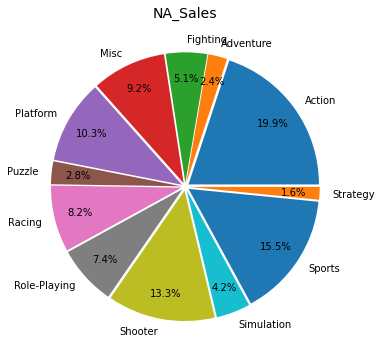

In [18]:
pie, ax = plt.subplots(figsize=[10,6])
labels = Regenre1['NA_Sales'].keys()
plt.pie(x=Regenre1['NA_Sales'], autopct="%.1f%%",explode=[0.03]*12, labels=labels, pctdistance=0.8)
plt.title("NA_Sales", fontsize=14);
pie.savefig("NA_Sales")


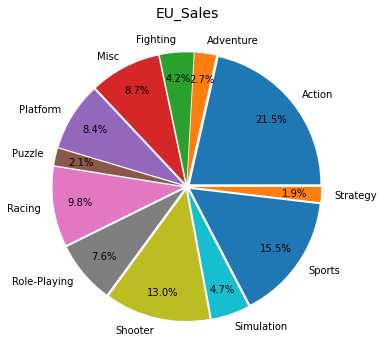

In [19]:
pie, ax = plt.subplots(figsize=[10,6])
labels = Regenre1['EU_Sales'].keys()
plt.pie(x=Regenre1['EU_Sales'], autopct="%.1f%%",explode=[0.03]*12, labels=labels, pctdistance=0.8)
plt.title("EU_Sales", fontsize=14);
pie.savefig("EU_Sales")

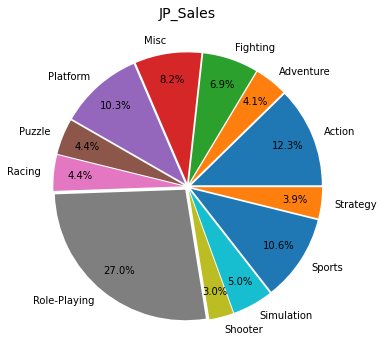

In [20]:
pie, ax = plt.subplots(figsize=[10,6])
labels = Regenre1['JP_Sales'].keys()
plt.pie(x=Regenre1['JP_Sales'], autopct="%.1f%%", explode=[0.03]*12,labels=labels, pctdistance=0.8)
plt.title("JP_Sales", fontsize=14);
pie.savefig("JP_Sales")

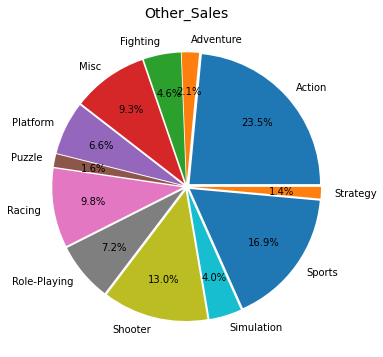

In [21]:
pie, ax = plt.subplots(figsize=[10,6])
labels = Regenre1['Other_Sales'].keys()
plt.pie(x=Regenre1['Other_Sales'], autopct="%.1f%%",explode=[0.03]*12, labels=labels, pctdistance=0.7)
plt.title("Other_Sales", fontsize=14);
pie.savefig("Other_Sales")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


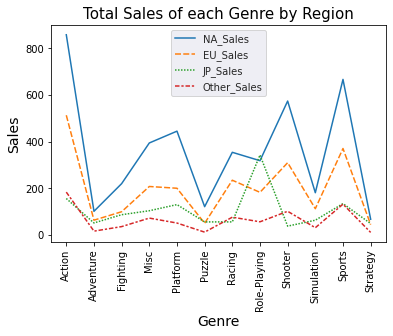

In [22]:
import matplotlib.ticker as ticker
ax = sns.lineplot(data=Regenre1)
sns.set()
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Total Sales of each Genre by Region', fontsize=15)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Genre', fontsize=14)
plt.legend(fontsize=10,loc='best')
plt.xticks(rotation=90)
plt.show()

# **3. 연도별 게임의 트렌드가 있을까?/카이제곱**

3-(1) 연도별 모든 장르의 총 출고량

In [28]:
# 모든 지역 모든 장르 토탈   Year에서 N/A인 데이터는 다 drop했더니 2017-2020까지 출고량이 거의 없는데..
df3 = df[['Genre','Total','Year']] #.set_index(df['Year'])
df3 = df3.pivot_table(index='Year', columns='Genre', values='Total',aggfunc=sum).fillna(0)
df3

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1980,0.340000,0.00,0.770000,2.700000,0.000000,0.000000,0.000000,0.000000,7.070000,0.000000,0.000000,0.00
1981,14.790000,0.00,0.000000,0.000000,6.920000,2.250000,0.480000,0.000000,10.020000,0.440000,0.780000,0.00
1982,6.500000,0.00,0.000000,0.870000,5.030000,10.040000,1.570000,0.000000,3.810000,0.000000,1.060000,0.00
1983,2.860000,0.40,0.000000,2.140000,6.930000,0.780000,0.000000,0.000000,0.490000,0.000000,3.200000,0.00
1984,1.850000,0.00,0.000000,1.450000,0.690000,3.140000,5.950000,0.000000,31.100000,0.000000,6.170000,0.00
1985,3.520000,0.00,1.050000,0.000000,43.170000,3.210000,0.000000,0.000000,1.000000,0.040000,1.960000,0.00
1986,13.740000,0.00,0.000000,0.000000,9.390000,0.000000,1.960000,2.520000,3.890000,0.000000,5.579999,0.00
1987,1.110000,4.38,5.419999,0.000000,1.740000,0.000000,0.000000,4.650000,0.690000,0.000000,3.710000,0.00
1988,1.740000,0.00,0.000000,0.000000,27.730000,5.580000,2.140000,5.880000,0.510000,0.030000,3.600000,0.00


In [29]:
chi2_contingency(df3, correction = False)
p<0.05

True

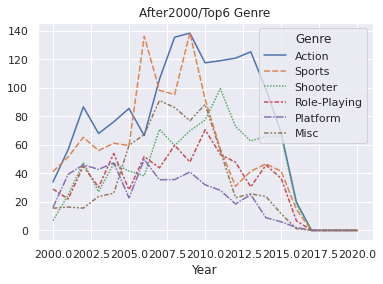

In [30]:
#2000년 이후에 상위 6개의 장르 
G2000 = df3.loc['2000':'2020']
#df3 = df[['Genre','Total','Year']] #.set_index(df['Year'])
G2000 = G2000[['Action','Sports','Shooter','Role-Playing','Platform','Misc']]
sns.lineplot(data=G2000).set_title("After2000/Top6 Genre")  #연도별 게임의 트렌드가 있을까? 
sns.set(rc={'figure.figsize':(15,13)})#plt.xticks(rotation=90)

(array([1975., 1980., 1985., 1990., 1995., 2000., 2005., 2010., 2015.,
        2020., 2025.]), <a list of 11 Text major ticklabel objects>)

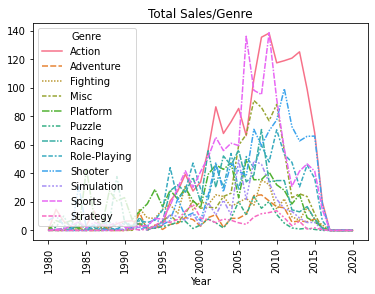

In [ ]:
#전체 연도별 장르
sns.lineplot(data=df3).set_title("Total Sales/Genre")  #연도별 게임의 트렌드가 있을까? 
sns.set(rc={'figure.figsize':(15,13)})
plt.xticks(rotation=90)


3-(2) 연도별 모든 플랫폼의 총 출고량

In [33]:
# 모든 지역 모든 플랫폼 토탈
df4 = df[['Platform','Total','Year']] #.set_index(df['Year'])
df4 = df4.pivot_table(index='Year', columns='Platform', values='Total',aggfunc=sum).fillna(0)
df4

Platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980,10.88,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1981,35.68,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1982,28.88,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1983,5.84,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,10.960000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1984,0.27,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,50.080000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1985,0.45,0.00,0.000000,0.00,0.020000,0.000000,0.000000,0.00,0.00,0.00,0.000000,53.440000,0.00,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1986,0.67,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,36.409999,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1987,1.94,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,19.759999,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1988,0.74,0.00,0.000000,0.00,0.000000,1.430000,0.000000,0.00,0.00,0.00,0.000000,45.010000,0.00,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
chi2_contingency(df4, correction = False)
p<0.05

True

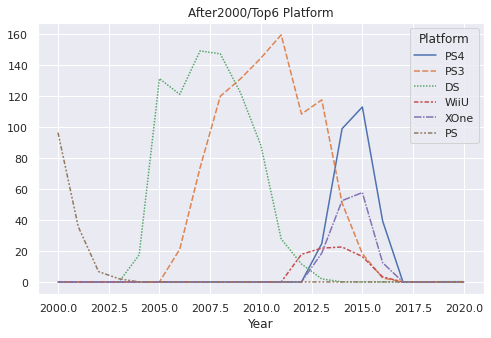

In [41]:
#2000년 이후 플랫폼
P2000 =df4.loc['2000':'2020']
P2000 = P2000[['PS4','PS3','DS','WiiU','XOne','PS']] #가정용8세대     #[['PS2','PS3','X360','Wii','PS','DS']]
sns.lineplot(data=P2000).set_title("After2000/Top6 Platform")  #연도별 게임의 트렌드가 있을까? 
sns.set(rc={'figure.figsize':(8,5)}) #plt.xticks(rotation=90)    #sns.factorplot(x="Year", y="Platform", hue="kind", data=PS, ci= .95)


(array([1975., 1980., 1985., 1990., 1995., 2000., 2005., 2010., 2015.,
        2020., 2025.]), <a list of 11 Text major ticklabel objects>)

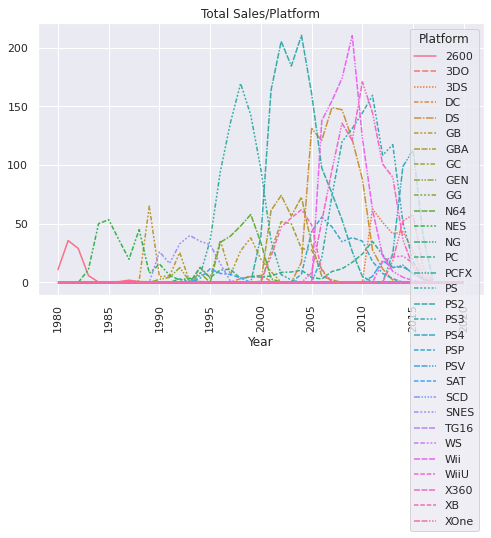

In [42]:
#전체 연도별 플랫폼
sns.lineplot(data=df4).set_title("Total Sales/Platform")  #
sns.set(rc={'figure.figsize':(25,17)})
plt.xticks(rotation=90)

# **4. 플랫폼의 주기**

In [ ]:
plat = df[['Platform','Year']]
PS=plat[plat['Platform'].isin(['PS','PS2','PS3','PS4','PSP','PSV'])] 
DS=plat[plat['Platform'].isin(['DS','3DS'])] 
Wii=plat[plat['Platform'].isin(['Wii','WiiU'])] 
XB =plat[plat['Platform'].isin(['XB','X360','XOne'])] 
PC = plat[plat['Platform'].isin(['PC','PCFX'])] 
NES = plat[plat['Platform'].isin(['NES','SNES'])] 
rest1 = plat[plat['Platform'].isin(['GEN','N64','SAT'])] 
rest2 = plat[plat['Platform'].isin(['2600','GB','WS'])] 
rest3 = plat[plat['Platform'].isin(['SCD','GG','3DO','TG16'])] 
#sns.boxplot(data=PS, x='Year', y='Platform',order=['PS','PS2','PS3','PS4'])
#sns.set(rc={'figure.figsize':(7,5)})


Text(0.5, 1.0, 'Not Series')

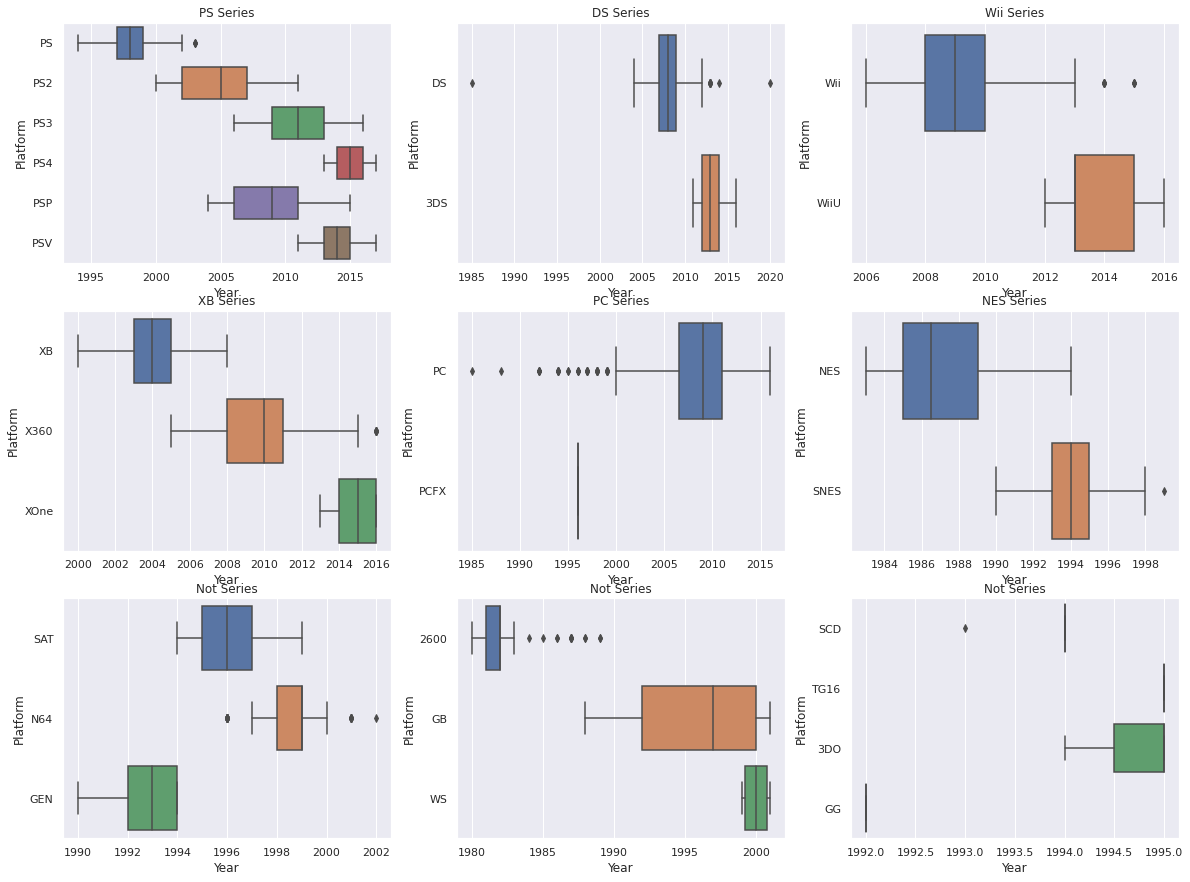

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
sns.boxplot(ax=axes[0, 0], data=PS, x='Year', y='Platform',order=['PS','PS2','PS3','PS4','PSP','PSV']).set_title("PS Series")
sns.boxplot(ax=axes[0, 1], data=DS, x='Year', y='Platform',order=['DS','3DS']).set_title("DS Series")
sns.boxplot(ax=axes[0, 2], data=Wii, x='Year', y='Platform',order=['Wii','WiiU']).set_title("Wii Series")
sns.boxplot(ax=axes[1, 0], data=XB, x='Year', y='Platform',order=['XB','X360','XOne']).set_title("XB Series")
sns.boxplot(ax=axes[1, 1], data=PC, x='Year', y='Platform',order=['PC','PCFX']).set_title("PC Series")
sns.boxplot(ax=axes[1, 2], data=NES, x='Year', y='Platform',order=['NES','SNES']).set_title("NES Series")
sns.boxplot(ax=axes[2, 0], data=rest1, x='Year', y='Platform').set_title("Not Series")
sns.boxplot(ax=axes[2, 1], data=rest2, x='Year', y='Platform').set_title("Not Series")
sns.boxplot(ax=axes[2, 2], data=rest3, x='Year', y='Platform').set_title("Not Series")

# **5. 그 외 시각화**

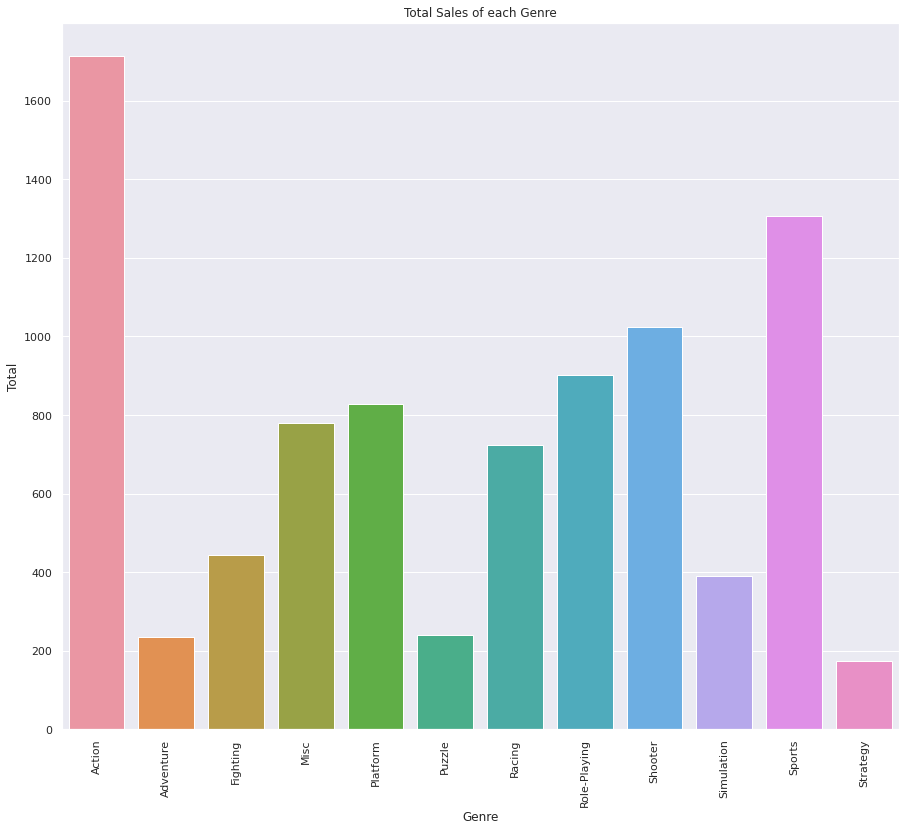

In [ ]:
#총 출고량에 따른 장르 순위
df5 = df[['Genre','Total']]
df5 = df5.groupby(df5['Genre']).sum()
df5 = df5.reset_index()
sns.barplot(data= df5, x= "Genre", y= "Total").set_title('Total Sales of each Genre')
plt.xticks(rotation=90)
plt.show()

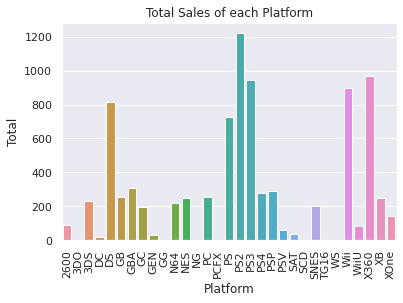

In [ ]:
#총 출고량에 따른 플랫폼 순위
df6 = df[['Platform','Total']]
df6 = df6.groupby(df6['Platform']).sum()
df6 = df6.reset_index()
df6 = sns.barplot(data= df6, x= "Platform", y= "Total").set_title('Total Sales of each Platform')
plt.xticks(rotation=90)
plt.show()

# **6. 장르와 플랫폼은 연관이 있을까?/카이제곱**

In [ ]:

df2 = df[['Genre','Total','Platform']] 
df2 = df2.pivot_table(index='Platform', columns='Genre', values='Total',aggfunc=sum).fillna(0)
df2


Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Platform,,,,,,,,,,,,
2600,26.310000,0.40,0.770000,3.570000,13.260000,13.670000,2.320000,0.000000,22.960000,0.440000,2.280000,0.00
3DO,0.000000,0.06,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00
3DS,56.489999,4.74,10.440000,10.470000,32.250000,5.550000,14.430000,61.340000,1.230000,26.629999,6.180000,2.07
DC,1.260000,2.50,1.830000,0.000000,2.530000,0.000000,2.650000,0.680000,0.330000,0.520000,3.650000,0.00
DS,113.990000,47.11,7.200000,137.519999,77.340000,83.390000,38.540000,126.490000,8.100000,131.160000,31.650000,14.70
GB,7.930000,17.15,0.000000,13.350000,53.879999,47.470000,4.550000,88.240000,1.190000,3.550000,9.060000,8.06
GBA,54.130000,11.87,4.160000,28.380000,77.990000,11.989999,18.810000,64.150000,3.560000,5.940000,16.320000,7.46
GC,37.110000,5.93,18.430000,16.440000,28.590000,3.850000,21.770000,13.040000,13.610000,8.610000,24.360000,4.28
GEN,2.740000,0.19,5.890000,0.030000,15.440000,0.000000,0.260000,0.270000,0.130000,0.000000,3.210000,0.19


In [ ]:
'''
가장 출고량이 높은 Genre와 Platform에는 서로 연관성이 있을까?
H0 ; Genre와 Platform에는 연관성이 없다
H1 ; Genre와 Platform에는 연관성이 있다
'''
from scipy.stats import chi2_contingency
from scipy import stats
stat, p, dof, expected = chi2_contingency(df2)
p<0.05    #귀무가설이 기각되고 대립가설이 채택되므로 Genre와 Platform에는 어떠한 연관성이 있다.

True

In [ ]:
#Action에서 가장 출고량이 많은 플랫폼
genpla = df[['Genre','Platform','Total']]
genpla = genpla[genpla['Genre'] == 'Action'].reset_index(drop=True)
platsum = genpla.groupby(genpla['Platform']).sum()
platsum

,Total
Platform,
2600,26.310000
3DS,56.489999
DC,1.260000
DS,113.990000
GB,7.930000
GBA,54.130000
GC,37.110000
GEN,2.740000
N64,29.310000


In [ ]:
#Action에서 가장 많이 사용되는 플랫폼
genpla1 = df[['Genre','Platform']]
genpla1 = genpla1[genpla1['Genre'] == 'Action'].reset_index(drop=True)
genpla1=genpla1.value_counts()
genpla1

Genre   Platform
Action  PS3         369
        PS2         344
        DS          335
        X360        318
        Wii         229
        PSP         216
        3DS         180
        GBA         162
        PC          160
        PS          153
        XB          152
        PSV         141
        PS4         121
        GC           98
        XOne         68
        WiiU         63
        2600         55
        N64          36
        NES          13
        SNES         12
        GB            6
        GEN           3
        SAT           3
        DC            3
dtype: int64

# **TOP 10 출고량 순위**

In [26]:
#df4['Total'].rank(method='min', ascending=False)

df.sort_values(by="Total", ascending=False).groupby("Genre").head(2)


,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
Name,,,,,,,,,
Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.460000,82.740000
Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.770000,40.240000
Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.310000,35.830000
Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.960000,33.000000
Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.000000,31.380000
Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.580000,30.260000
New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.900000,30.010000
Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.850000,29.010000
Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.470000,28.310000
